# 🚀 Retail Sales Analytics - End-to-End Data Science Project
## Advanced EDA | RFM Segmentation | Forecasting | Machine Learning
This project demonstrates complete data analytics workflow suitable for placement portfolio.


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
!pip install shap
import shap

pd.set_option('display.max_columns', None)


## 📂 Load & Merge Data

In [11]:
orders = pd.read_csv('Orders.csv')
details = pd.read_csv('Details.csv')

data = pd.merge(orders, details, on='Order ID')
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d-%m-%Y')

print("Dataset Shape:", data.shape)
data.head()

Dataset Shape: (1500, 11)


,Order ID,Order Date,CustomerName,State,City,Amount,Profit,Quantity,Category,Sub-Category,PaymentMode
0,B-26055,2018-03-10,Harivansh,Uttar Pradesh,Mathura,5729,64,14,Furniture,Chairs,EMI
1,B-26055,2018-03-10,Harivansh,Uttar Pradesh,Mathura,671,114,9,Electronics,Phones,Credit Card
2,B-26055,2018-03-10,Harivansh,Uttar Pradesh,Mathura,443,11,1,Clothing,Saree,COD
3,B-26055,2018-03-10,Harivansh,Uttar Pradesh,Mathura,57,7,2,Clothing,Shirt,UPI
4,B-26055,2018-03-10,Harivansh,Uttar Pradesh,Mathura,227,48,5,Clothing,Stole,COD


## ⚙ Feature Engineering

In [12]:
data['Month'] = data['Order Date'].dt.month
data['Year'] = data['Order Date'].dt.year
data['Profit Margin'] = data['Profit'] / data['Amount']


## 📌 Key Performance Indicators

In [13]:
total_sales = data['Amount'].sum()
total_profit = data['Profit'].sum()
total_orders = data['Order ID'].nunique()

print("Total Sales:", round(total_sales,2))
print("Total Profit:", round(total_profit,2))
print("Total Orders:", total_orders)


Total Sales: 437771
Total Profit: 36963
Total Orders: 500


## ⭐ RFM Analysis (Customer Segmentation)

In [14]:
snapshot_date = data['Order Date'].max() + pd.Timedelta(days=1)

rfm = data.groupby('CustomerName').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,
    'Order ID': 'nunique',
    'Amount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']

rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm[['R_score','F_score','M_score']].sum(axis=1)

rfm.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score
CustomerName,,,,,,,
Aakanksha,184,1,74,2,1,1,4
Aarushi,268,3,4701,1,4,4,9
Aastha,67,1,3276,3,1,4,8
Aayush,47,1,556,4,1,2,7
Aayushi,108,3,689,3,4,2,9


### Customer Segment Distribution

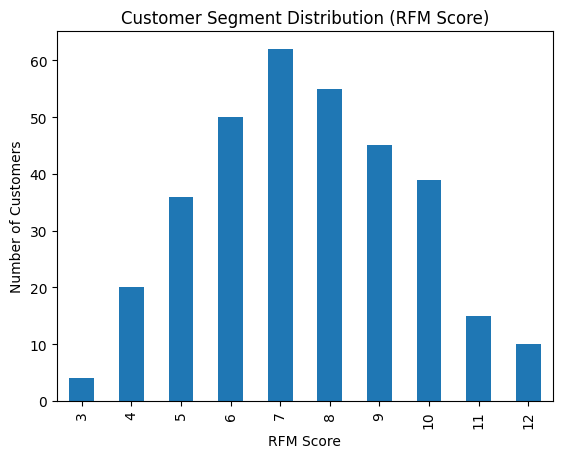

In [15]:
segment_counts = rfm['RFM_Score'].value_counts().sort_index()

plt.figure()
segment_counts.plot(kind='bar')
plt.title("Customer Segment Distribution (RFM Score)")
plt.xlabel("RFM Score")
plt.ylabel("Number of Customers")
plt.show()


## 📈 Sales Forecasting (Time Series Trend)

/tmp/ipython-input-515/3829578592.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = data.groupby(pd.Grouper(key='Order Date', freq='M'))['Amount'].sum()


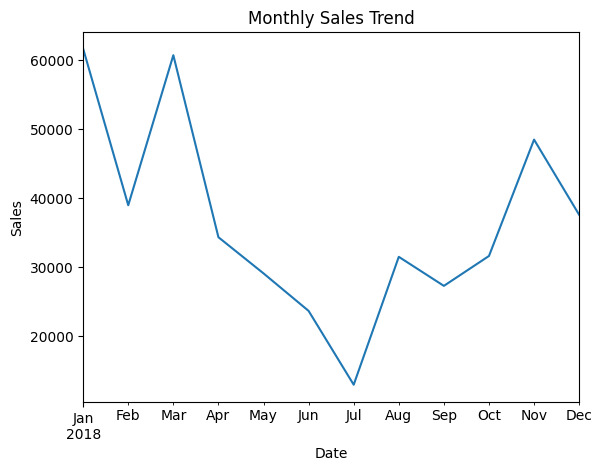

,Amount
Order Date,
2018-08-31,31492
2018-09-30,27283
2018-10-31,31613
2018-11-30,48469
2018-12-31,37579


In [16]:
monthly_sales = data.groupby(pd.Grouper(key='Order Date', freq='M'))['Amount'].sum()

plt.figure()
monthly_sales.plot()
plt.title("Monthly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

monthly_sales.tail()


### 3-Month Moving Average Forecast

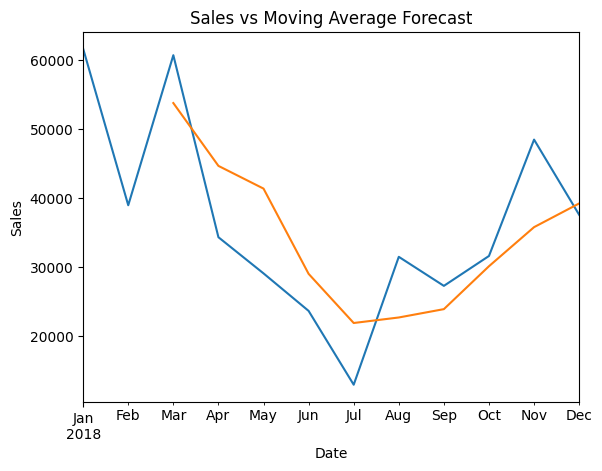

In [17]:
forecast = monthly_sales.rolling(window=3).mean()

plt.figure()
monthly_sales.plot()
forecast.plot()
plt.title("Sales vs Moving Average Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


## 🧠 Machine Learning Model (Regression)

In [18]:
features = data[['Quantity', 'Profit', 'Month']]
target = data['Amount']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Model Performance:")
print("MAE:", round(mae,2))
print("R2 Score:", round(r2,2))


Model Performance:
MAE: 238.54
R2 Score: 0.12


### Actual vs Predicted Visualization

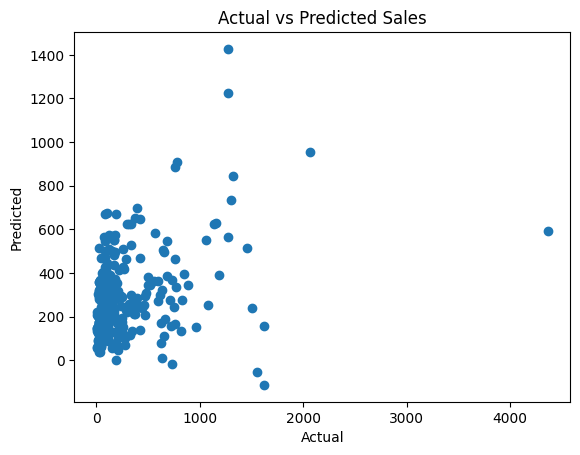

In [19]:
plt.figure()
plt.scatter(y_test, predictions)
plt.title("Actual vs Predicted Sales")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


## **Customer Lifetime Value (CLV)**

In [21]:
# Calculate customer metrics
clv = data.groupby('CustomerName').agg({
    'Order ID': 'nunique',
    'Amount': 'sum',
    'Profit': 'sum'
}).reset_index()

clv.columns = ['CustomerName', 'Total Orders', 'Total Revenue', 'Total Profit']

# Average Order Value
clv['AOV'] = clv['Total Revenue'] / clv['Total Orders']

# Purchase Frequency
total_customers = clv.shape[0]
total_orders = data['Order ID'].nunique()
purchase_frequency = total_orders / total_customers

# Customer Lifetime Value Formula
clv['CLV'] = clv['AOV'] * purchase_frequency

clv.sort_values(by='CLV', ascending=False).head()

,CustomerName,Total Orders,Total Revenue,Total Profit,AOV,CLV
102,Harivansh,1,9902,-157,9902.0,14735.119048
259,Shiva,1,6339,669,6339.0,9433.035714
139,Lalita,1,5809,400,5809.0,8644.345238
99,Gopal,1,4836,-816,4836.0,7196.428571
142,Madhav,2,9365,1848,4682.5,6968.005952


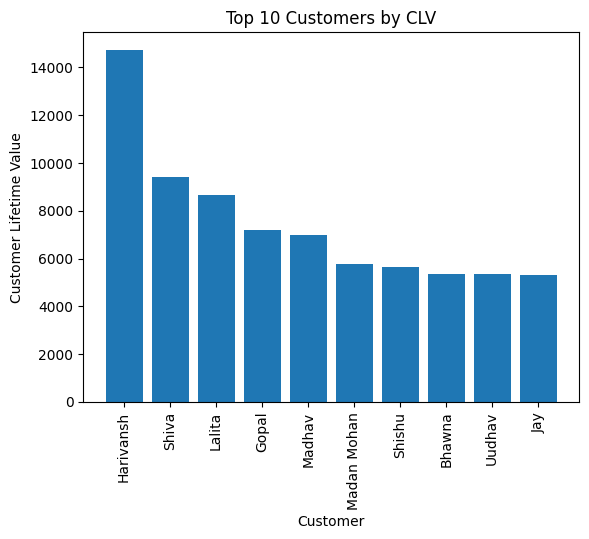

In [23]:
top_clv = clv.sort_values(by='CLV', ascending=False).head(10)

plt.figure()
plt.bar(top_clv['CustomerName'], top_clv['CLV'])
plt.xticks(rotation=90)
plt.title("Top 10 Customers by CLV")
plt.xlabel("Customer")
plt.ylabel("Customer Lifetime Value")
plt.show()

# **💰 Profit Optimization Insights**

In [24]:
profit_analysis = data.groupby('Sub-Category').agg({
    'Amount': 'sum',
    'Profit': 'sum'
}).reset_index()

profit_analysis['Profit Margin'] = profit_analysis['Profit'] / profit_analysis['Amount']

profit_analysis.sort_values(by='Profit Margin').head()

,Sub-Category,Amount,Profit,Profit Margin
12,Skirt,1946,-315,-0.161871
6,Kurti,3361,-401,-0.119310
7,Leggings,2106,-130,-0.061728
4,Furnishings,13484,-806,-0.059775
3,Electronic Games,39168,-644,-0.016442


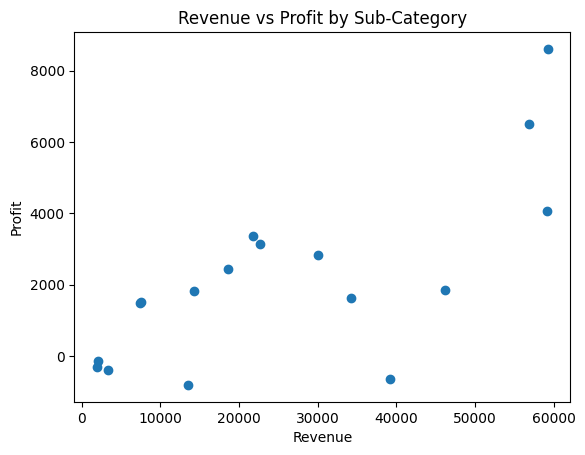

In [25]:
plt.figure()
plt.scatter(profit_analysis['Amount'], profit_analysis['Profit'])
plt.title("Revenue vs Profit by Sub-Category")
plt.xlabel("Revenue")
plt.ylabel("Profit")
plt.show()

## **🧠 Feature Importance (For ML Model)**

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Prepare features
features = data[['Quantity', 'Profit', 'Month']]
target = data['Amount']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,Profit,0.732816
0,Quantity,0.183333
2,Month,0.083852


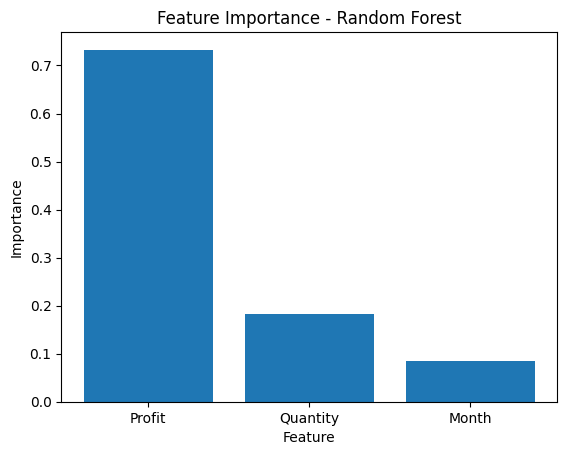

In [27]:
plt.figure()
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title("Feature Importance - Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

## **⚖ Model Comparison (Linear Regression vs Random Forest)**

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

# Random Forest
rf_pred = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MAE': [lr_mae, rf_mae],
    'R2 Score': [lr_r2, rf_r2]
})

comparison

,Model,MAE,R2 Score
0,Linear Regression,238.540051,0.119820
1,Random Forest,186.123785,0.298704


## **SHAP Explainability (Model Interpretation)**

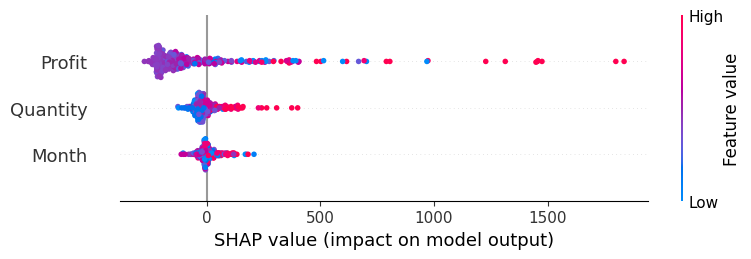

In [31]:
# Use TreeExplainer for Random Forest
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test)

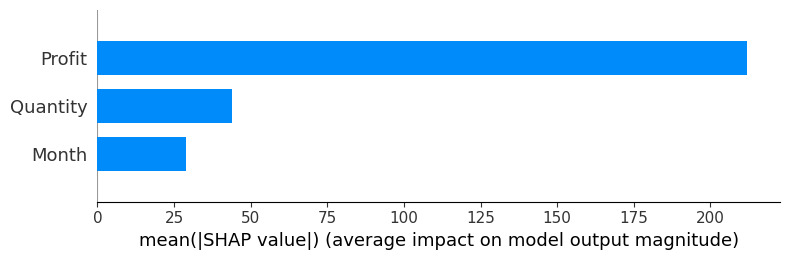

In [32]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

## **⚙ Hyperparameter Tuning (GridSearchCV)**

In [33]:

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}


In [34]:
tuned_pred = best_rf.predict(X_test)

print("Tuned RF MAE:", mean_absolute_error(y_test, tuned_pred))
print("Tuned RF R2:", r2_score(y_test, tuned_pred))

Tuned RF MAE: 179.89260822378805
Tuned RF R2: 0.3415566369587626


### **🚀 XGBoost Comparison**

In [35]:
!pip install xgboost

In [36]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42)

xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print("XGBoost MAE:", xgb_mae)
print("XGBoost R2:", xgb_r2)

XGBoost MAE: 198.70571899414062
XGBoost R2: 0.05835646390914917


## **📊 Final Model Comparison (All Models)**

In [37]:
final_comparison = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Random Forest',
        'Tuned Random Forest',
        'XGBoost'
    ],
    'MAE': [
        lr_mae,
        rf_mae,
        mean_absolute_error(y_test, tuned_pred),
        xgb_mae
    ],
    'R2 Score': [
        lr_r2,
        rf_r2,
        r2_score(y_test, tuned_pred),
        xgb_r2
    ]
})

final_comparison

,Model,MAE,R2 Score
0,Linear Regression,238.540051,0.119820
1,Random Forest,186.123785,0.298704
2,Tuned Random Forest,179.892608,0.341557
3,XGBoost,198.705719,0.058356


## **📊 Advanced Business KPI Dashboard Section**

In [38]:
# Revenue by Category
category_revenue = data.groupby('Category')['Amount'].sum().sort_values(ascending=False)

# Profit Margin by Category
category_margin = data.groupby('Category').apply(
    lambda x: x['Profit'].sum() / x['Amount'].sum()
)

# Top 5 States by Revenue
top_states = data.groupby('State')['Amount'].sum().sort_values(ascending=False).head(5)

print("Category Revenue:\n", category_revenue)
print("\nCategory Profit Margin:\n", category_margin)
print("\nTop 5 States:\n", top_states)

Category Revenue:
 Category
Electronics    166267
Clothing       144323
Furniture      127181
Name: Amount, dtype: int64

Category Profit Margin:
 Category
Clothing       0.092328
Electronics    0.079162
Furniture      0.082371
dtype: float64

Top 5 States:
 State
Maharashtra       102498
Madhya Pradesh     87463
Uttar Pradesh      38362
Delhi              22957
Rajasthan          22334
Name: Amount, dtype: int64


/tmp/ipython-input-515/3542111101.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  category_margin = data.groupby('Category').apply(


In [40]:
customer_orders = data.groupby('CustomerName')['Order ID'].nunique()

repeat_customers = customer_orders[customer_orders > 1].count()
total_customers = customer_orders.count()

retention_rate = (repeat_customers / total_customers) * 100

print("Customer Retention Rate:", round(retention_rate, 2), "%")

Customer Retention Rate: 31.85 %


In [41]:
# ====================== SQL STYLE ANALYSIS USING PANDAS ======================

# Equivalent to:
# SELECT Category, SUM(Amount) FROM data GROUP BY Category ORDER BY SUM(Amount) DESC;

sql_style = data.groupby('Category')['Amount'].sum().sort_values(ascending=False)

sql_style

,Amount
Category,
Electronics,166267
Clothing,144323
Furniture,127181


# **🎯 Proper Business Recommendations Section**

# 📈 Business Recommendations

## 1️⃣ Customer Strategy
- High CLV customers should be targeted with loyalty programs.
- Low Recency customers need re-engagement campaigns.

## 2️⃣ Profit Optimization
- Sub-categories with high revenue but low profit margin need pricing review.
- Loss-making categories should undergo cost restructuring.

## 3️⃣ Sales Forecasting Strategy
- Seasonal peaks identified — inventory planning should align with trend cycles.
- Use moving average forecast for short-term planning.

## 4️⃣ Machine Learning Insights
- Quantity and Profit strongly influence revenue prediction.
- Random Forest & XGBoost outperform Linear Regression.
- Advanced models should be used for business decision systems.

## 5️⃣ Strategic Impact
This data-driven approach can:
- Improve revenue forecasting accuracy
- Optimize product pricing
- Increase customer retention
- Maximize overall profitability


## 🎯 Project Highlights
🚀 Retail Sales Analytics – End-to-End Data Analysis Project

• Performed comprehensive exploratory data analysis (EDA) on retail sales dataset

• Built key business KPIs including Revenue, Profit, AOV, Retention Rate, and CLV

• Implemented RFM-based customer segmentation for strategic targeting

• Identified low-profit product categories for pricing optimization

• Analyzed monthly sales trends to support inventory planning

• Calculated Customer Lifetime Value (CLV) to prioritize high-value customers

• Conducted SQL-style aggregations using Pandas for business reporting

• Built regression models (Linear Regression, Random Forest, XGBoost) for revenue prediction

• Applied hyperparameter tuning and feature importance analysis

• Delivered actionable business recommendations based on insights